# Continuous Normalizing Flows for Nambu-Goto string

**If this code is useful for your research, please cite us:**


A differentiable ODE solver is needed to train the Continuous Normalizing Flows; we used the library [torchdiffeq](https://github.com/rtqichen/torchdiffeq).

In [1]:
try:
    from torchdiffeq import odeint_adjoint as odeint
except ModuleNotFoundError:
    !pip -q install git+https://github.com/rtqichen/torchdiffeq
    from torchdiffeq import odeint_adjoint as odeint

In [2]:
import torch
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [3]:
def grab(var):
    if torch.is_tensor(var):
        return var.detach().cpu().numpy()
    else:
        return var

In [4]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


# Prior

The prior used in our work is a Normal distribution.

In [5]:
class Prior:
  def __init__(self,L,R,sd):
    self.V=L*R
    self.sd=sd
    #we fixed the mean to zero
  def sample_n(self, batch):
    z=torch.Tensor(self.sd*np.random.randn(batch,self.V))
    return z
  def log_prob(self,z):
    logz=z**2/(2*self.sd**2)
    logz+=0.5*torch.log(torch.Tensor([2.0*torch.pi*self.sd**2]))
    return -logz.sum(-1)


# Target

The target theory is the Nambu-Goto string regularized on a bi-dimensional lattice $\Lambda$ with lattice step $a=1$ and sizes $|L\times R|$:
$$S[\phi]=\sigma\sum_{x\in \Lambda}\biggl(\sqrt{1+(\partial_\mu\phi)^2/σ}-1 \biggr)$$
where $\sigma$ is the string tension, and:
$$(\partial_\mu\phi)^2=\sum_{\mu=1}^2\bigl(\phi(x)-\phi(x-\hat{\mu})\bigr)^2$$
where $\hat{\mu}$ is a unit vector pointing the worldsheet coordinates $(\tau,\epsilon)$.

We fixed periodic boundary conditions along $L$ and Dirchilet along $R$.

Since the Dirichlet boundaries are fixed, the "active" volume of the lattices generated by the CNFs is $|L\times (R-1)|$. To use the Dirichlet boundary conditions, we add a zero padding in $\epsilon=R$, and we then use periodic boundary conditions to obtain the Dirichlet boundary in $\epsilon=0$.

In [6]:
dir=torch.nn.ZeroPad2d((0,1,0,0))
def S(cfgs,sigma):
  cfgs=dir(cfgs)
  act=(cfgs-torch.roll(cfgs,1,1))**2+(cfgs-torch.roll(cfgs,1,2))**2
  act=(torch.sqrt(1+act/sigma)-1).sum((1,2))
  return sigma*act

# CNF

The CNFs used in our work use a linear, continuous in-time, vector field:
$$\frac{d\phi(t)_x}{dt}=g_\theta(\phi(t),t)=\sum_{y,f}K(t)_fW_{f,x,y}\phi(t)_y$$
where $x$ and $y$ represent the active sites of the lattices and the temporal $K(t)\in \mathbb{R}^F$ is inspired by: [Learning Lattice Quantum Field Theories with Equivariant Continuous Flows](https://arxiv.org/abs/2207.00283).

The divergence of the vector field can be computed as:
$$\bigl(\nabla \cdot g_\theta)(\phi(t),t)=Tr\biggl[ \sum_{f} K(t)_f W_f \biggr]$$

Code for the temporal kernel $K(t)$:

In [7]:
def cos_base(mode,t,T):
  return torch.cos(2.0*torch.pi*t*mode/T)

def sin_base(mode,t,T):
  return torch.sin(2.0*torch.pi*t*mode/T)

def make_K(t,T,F):
  #F must be odd!!!
  return torch.hstack((torch.tensor([1.0]),cos_base(torch.arange(1,(F-1)/2+1,1),t,T),sin_base(torch.arange(1,(F-1)/2+1,1),t,T)))

Vector Field:

In [8]:
class G(torch.nn.Module):
    def __init__(self,T,L,R,F):
        super().__init__()
        self.T=T
        self.F=F
        self.w = torch.nn.Parameter(torch.zeros(L*R,L*R,F))  #Identity initialization

    def forward(self,t,data):
        z, logz = data[0], data[1]
        K=make_K(t,self.T,self.F)
        dlogP=torch.ones(z.shape[0])*torch.diag(torch.matmul(self.w,K)).sum(-1)  #Divergence of the vector field
        dx=torch.matmul(z,torch.matmul(self.w,K)) #Vector field
        return dx, -dlogP


The generated samples $\phi$ and the learned density $q_\theta$ can be computed by solving the ODEs:
$$
\begin{cases}
      \frac{d\phi(t)_x}{dt}=g_\theta(\phi(t),t)\\
       \frac{d \log q(\phi(t))}{d t}=-\bigl(\nabla \cdot g_\theta)(\phi(t),t).
  \end{cases}\
  $$
with boundary conditions: $\phi(0)=z$ (z prior configurations) and $\phi(T)=\phi$ where $T=1$ (hyperparameter):
```python
z = prior.sample_n(50000)
logz=prior.log_prob(z)
phi,logphi = odeint(g,(z,logz),times,method='rk4')
```

where 'odeint' is an ODE solver that must be differentiable through the adjoint sensitivity method: [Neural Ordinary Differential Equations
](https://arxiv.org/abs/1806.07366)

## Training of the CNFs

The training of the CNFs is done by minimizing the variational free energy:
$$F_q=\int d\phi q(\phi)[ \log q(\phi)+S(\phi)] $$
where $\phi$ are the generated samples and $\log q(\phi)$ the corresponding learned density.

Model's parameters:

In [9]:
T=1.0
L=20
R=19
sigma=100.0
F=3

In [10]:
g=G(T,L,R,F).to(torch_device)

In [11]:
sd=0.5 #Prior standard deviation

In [12]:
prior = Prior(L,R,sd)

In [13]:
dt=0.08

In [14]:
times=torch.arange(0,T+dt,dt) #Integration steps
times.shape

torch.Size([14])

Function used to compute $-\log Z$ and $ESS$:

In [15]:
def compute_metrics(w):
    N = len(w)
    logZ = logsumexp(-w)
    log_ess = 2.0 * logZ - logsumexp(-2 * w)
    ess_per_cfg = np.exp(log_ess) / N #ESS
    logZ = logZ - np.log(N) #logZ
    return ess_per_cfg, -logZ

In [16]:
history={'loss':[],'ESS':[]}

In [17]:
n_epochs=1000
batch_size=10000

Training loop:

In [18]:
optimizer = torch.optim.Adam(g.parameters(), lr=0.0005,betas=(0.8,0.9))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
for t in tqdm(range(n_epochs)):
    # Forward pass: Compute predicted phi by passing z to the model
    optimizer.zero_grad()
    z = prior.sample_n(batch_size)
    logz=prior.log_prob(z)

    ##ODE integration
    phi,logphi = odeint(g,(z,logz),times,method='rk4')

    # Compute and print loss and metrics
    s=S(phi[-1].reshape((-1,L,R)),sigma)
    w = logphi[-1]+s
    loss=w.mean()
    ess,betaF=compute_metrics(grab(w))
    history['loss'].append(grab(loss))
    history['ESS'].append(ess)
    print('Epoch:', t, 'loss:', grab(loss), '-logZ:', betaF, 'ESS:', ess, 'loss var:',grab(w.var()))
    #Backward
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 loss: -86.92631 -logZ: -104.29088796054334 ESS: 0.00016737651735674108 loss var: 44.780563
Epoch: 1 loss: -86.987564 -logZ: -107.14447225009413 ESS: 0.00011522933228473695 loss var: 44.43052
Epoch: 2 loss: -87.19322 -logZ: -108.80866444980116 ESS: 0.000102477707143855 loss var: 45.119392
Epoch: 3 loss: -87.3231 -logZ: -114.16434682284803 ESS: 0.00010004120721831129 loss var: 45.997147
Epoch: 4 loss: -87.4164 -logZ: -103.527986654391 ESS: 0.00027102057001700107 loss var: 44.162247
Epoch: 5 loss: -87.63565 -logZ: -108.3926335660121 ESS: 0.00013699908721429214 loss var: 44.421585
Epoch: 6 loss: -87.68933 -logZ: -111.09382832919569 ESS: 0.00010114017907962278 loss var: 44.095905
Epoch: 7 loss: -87.91746 -logZ: -103.93341267978163 ESS: 0.0006697187231599867 loss var: 43.73621
Epoch: 8 loss: -88.16827 -logZ: -103.83705342685194 ESS: 0.000433949585408176 loss var: 44.064125
Epoch: 9 loss: -88.348526 -logZ: -108.60290730868788 ESS: 0.00017463460519386777 loss var: 43.03885
Epoch: 10 l

In [ ]:
#Learning Curve

### Learning Curve

Loss:

Text(0.5, 0, '$epoch$')

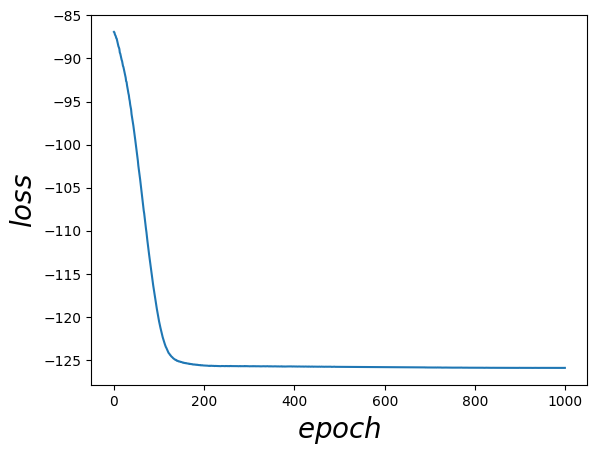

In [19]:
#Loss
varbF=np.asarray(history['loss'])
plt.plot(varbF)
plt.ylabel(r'$loss$', fontsize=20)
plt.xlabel(r'$epoch$', fontsize=20)

ESS:

Text(0.5, 0, '$epoch$')

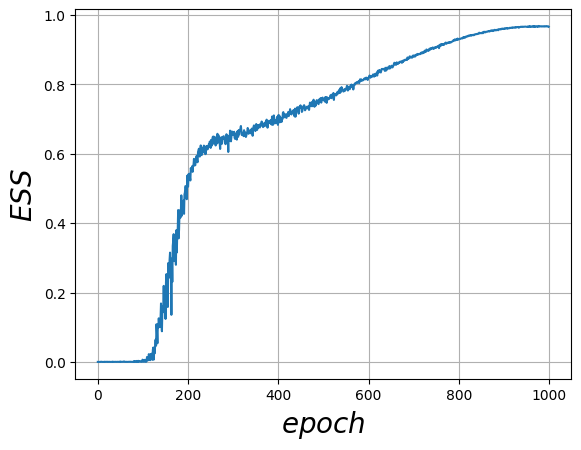

In [20]:
#ESS
ESS=np.asarray(history['ESS'])
plt.plot(ESS)
plt.grid()
plt.ylabel(r'$ESS$', fontsize=20)
plt.xlabel(r'$epoch$', fontsize=20)

### Simple test of $-\log Z$ and ESS on 50k samples

In [21]:
z = prior.sample_n(50000)
logz=prior.log_prob(z)
phi,logphi = odeint(g,(z,logz),times,method='rk4')

In [22]:
s=S(phi[-1].reshape((-1,L,R)),sigma)
w = logphi[-1]+s

In [23]:
ess,bF=compute_metrics(grab(w))

In [24]:
ess

0.966353754910973

In [25]:
bF

-125.9272157341444